# Example notebook

In [1]:
import perfume
import perfume.analyze
import pandas as pd
import bokeh.io
bokeh.io.output_notebook()

Loading BokehJS ...

## Setup

To start, set up some functions to benchmark.

In [2]:
import time
import numpy as np

def test_fn_1():
    good = np.random.poisson(20)
    bad = np.random.poisson(100)
    msec = np.random.choice([good, bad], p=[.99, .01])
    time.sleep(msec / 3000.)

def test_fn_1_no_outliers():
    time.sleep(np.random.poisson(20) / 3000.)

def test_fn_2():
    good = np.random.poisson(5)
    bad = np.random.poisson(150)
    msec = np.random.choice([good, bad], p=[.95, .05])
    time.sleep(msec / 3000.)

def test_fn_3():
    msec = max(1, np.random.normal(100, 10))
    time.sleep(msec / 3000.)

numbers = np.arange(0, 1, 1. / (3 * 5000000))

def test_fn_4():
    return np.sum(numbers)

# Create a variable named "samples", in this cell.  This way,
# if we change these functions, we'll reset the samples so we
# don't use old data with changed implementations.
samples = None

## Benchmark

Run the benchmark for a while by executing this cell.  Since we capture the output data in `samples`, and pass it back in as an argument, you can interrupt the cell, take a look at the output so far, and then execute this cell again to resume the benchmark.

In [3]:
samples = perfume.bench(test_fn_1, test_fn_2, test_fn_3, test_fn_4,
                        samples=samples)

## Analyzing the samples

Let's look at the format of the output, each function execution gets its begin and end time recorded:

In [4]:
samples.head()

function     test_fn_1                   test_fn_2                \
timing           begin           end         begin           end   
0         6.668990e+07  6.668991e+07  6.668991e+07  6.668991e+07   
1         6.668995e+07  6.668995e+07  6.668995e+07  6.668995e+07   
2         6.668999e+07  6.669000e+07  6.669000e+07  6.669000e+07   
3         6.669004e+07  6.669005e+07  6.669005e+07  6.669006e+07   
4         6.669010e+07  6.669011e+07  6.669011e+07  6.669011e+07   

function     test_fn_3                   test_fn_4                
timing           begin           end         begin           end  
0         6.668991e+07  6.668994e+07  6.668994e+07  6.668995e+07  
1         6.668995e+07  6.668998e+07  6.668998e+07  6.668999e+07  
2         6.669000e+07  6.669004e+07  6.669004e+07  6.669004e+07  
3         6.669006e+07  6.669009e+07  6.669009e+07  6.669010e+07  
4         6.669011e+07  6.669014e+07  6.669014e+07  6.669015e+07

One thing we can do is plot each function's distribution as it develops over simulated time:

In [5]:
perfume.analyze.cumulative_quantiles_plot(samples)

We can run a K-S test and see whether our functions are significantly different:

In [6]:
perfume.analyze.ks_test(perfume.analyze.timings(samples))

,test_fn_2,test_fn_3,test_fn_4
K-S test Z,,,
test_fn_1,8.494414,8.831940,7.650598
test_fn_2,NaN,8.606922,8.550668
test_fn_3,NaN,NaN,8.888194


We can convert them to elapsed timings instead of begin/end time points, get resampled timings to see outliers show a stronger presence, or isolate samples to be as if they ran by themselves

In [7]:
timings = perfume.analyze.timings(samples)
bt = perfume.analyze.bucket_resample_timings(samples)
isolated = perfume.analyze.isolate(samples)
isolated.head()

function  test_fn_1            test_fn_2             test_fn_3              \
timing        begin        end     begin       end       begin         end   
0          0.000000   7.879083  0.000000  1.532343    0.000000   29.188473   
1          7.879083  13.432623  1.532343  2.720641   29.188473   59.487223   
2         13.432623  21.638016  2.720641  3.269045   59.487223   93.088024   
3         21.638016  29.194047  3.269045  6.157080   93.088024  128.720489   
4         29.194047  34.441334  6.157080  7.378798  128.720489  160.600259   

function  test_fn_4             
timing        begin        end  
0          0.000000   9.990919  
1          9.990919  19.318506  
2         19.318506  28.697242  
3         28.697242  39.406731  
4         39.406731  48.569794

With these, and other charting libraries, you can do whatever you want with the data:

function,test_fn_1,test_fn_2,test_fn_3,test_fn_4
count,158.000000,158.000000,158.000000,158.000000
mean,7.099615,3.423204,33.526883,13.455989
std,2.382655,8.588543,3.039051,2.193190
min,3.280499,0.548404,25.672770,8.190510
25%,5.908776,1.335742,31.432720,12.909524
50%,6.904165,1.840656,33.613588,14.226354
75%,7.966824,2.353760,35.680228,14.863801
max,29.985672,56.681542,41.308623,16.934982


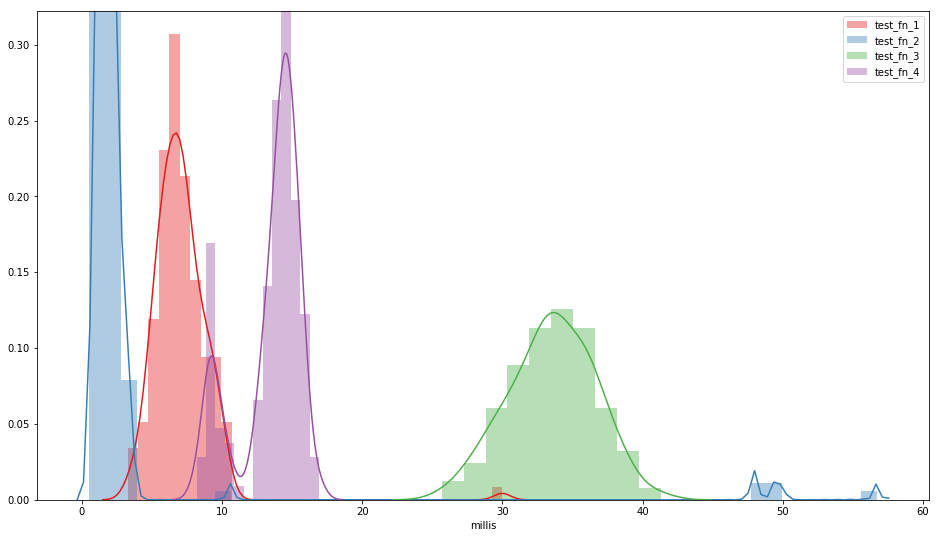

In [8]:
from bokeh import palettes
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots(figsize=(16, 9))
for col, color in zip(timings.columns, palettes.Set1[len(timings.columns)]):
    sns.distplot(timings[col], label=col, color=color, ax=ax,
#                  hist_kws=dict(cumulative=True),
#                  kde_kws=dict(cumulative=True)
                )
ax.set_xlabel('millis')
ax.legend()
timings.describe()

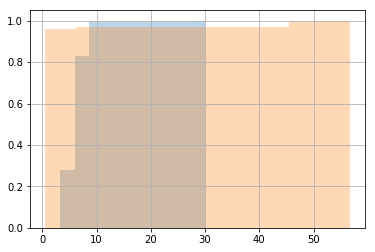

In [9]:
import matplotlib.pyplot as plt
timings['test_fn_1'].hist(cumulative=True, normed=1, alpha=0.3)
timings['test_fn_2'].hist(cumulative=True, normed=1, alpha=0.3)

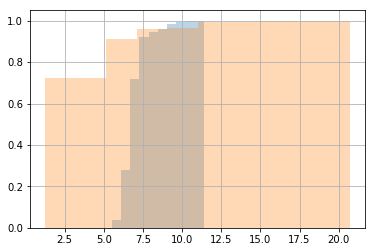

In [10]:
import matplotlib.pyplot as plt
bt['test_fn_1'].hist(cumulative=True, normed=1, alpha=0.3)
bt['test_fn_2'].hist(cumulative=True, normed=1, alpha=0.3)

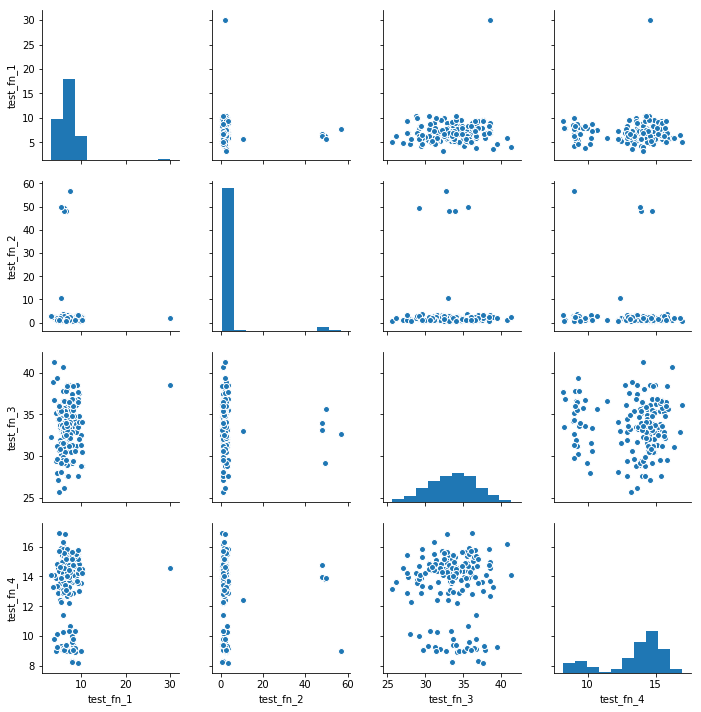

In [11]:
sns.pairplot(timings#, diag_kws={'cumulative': True}
            )

In [12]:
import scipy.stats
bt = perfume.analyze.bucket_resample_timings(samples)
(scipy.stats.ks_2samp(timings['test_fn_1'], timings['test_fn_2']),
 scipy.stats.ks_2samp(bt['test_fn_1'], bt['test_fn_2']))

(Ks_2sampResult(statistic=0.95569620253164556, pvalue=5.5872505324246181e-65),
 Ks_2sampResult(statistic=0.71199999999999997, pvalue=4.691029271698989e-223))